<a href="https://colab.research.google.com/github/Og31330/SHSPublic/blob/main/keras/Trajectory_softmax_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trajectory
Inspired from fiddle

Using tracknet dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import pandas as pd
import glob
import h5py, json
import os,time,sys
import math, random

# Analyze raw data

# Prepare data

In [ ]:
#df = pd.read_csv(f'/content/gdrive/MyDrive/DataSet_Training/Tracknet/game6/Clip1/Label.csv', header=0, sep=',')
all_files = glob.glob(os.path.join('/content/gdrive/MyDrive/DataSet_Training/Tracknet/csv', "*.csv"))
df = pd.concat((pd.read_csv(f, header=0, sep=',') for f in all_files), ignore_index=True)

display(df.tail(10))

# ---- Get the columns name as descriptions
#
synop_desc = list(df.columns)

# ---- Count the na values by columns
#
columns_na = df.isna().sum().tolist()

# ---- Show all of that
#


,file name,visibility,x-coordinate,y-coordinate,status
10305,0275.jpg,1,749.0,347.0,0.0
10306,0276.jpg,1,753.0,346.0,0.0
10307,0277.jpg,1,756.0,345.0,0.0
10308,0278.jpg,1,758.0,344.0,0.0
10309,0279.jpg,1,763.0,345.0,0.0
10310,0280.jpg,1,768.0,345.0,0.0
10311,0281.jpg,1,773.0,350.0,0.0
10312,0282.jpg,1,775.0,352.0,2.0
10313,0283.jpg,1,778.0,350.0,0.0
10314,0284.jpg,1,782.0,349.0,0.0


In [ ]:
# ---- Before : Lines with NaN

na_rows=df.isna().any(axis=1)
display( df[na_rows].head(10) )

# ---- Nice interpolation for plugging holes

df.interpolate(method='linear', inplace=True)

# ---- After

display(df[na_rows].head(10))

,file name,visibility,x-coordinate,y-coordinate,status
2082,0411.jpg,0,NaN,NaN,NaN
2083,0412.jpg,0,NaN,NaN,NaN
2084,0413.jpg,0,NaN,NaN,NaN
2296,0074.jpg,0,NaN,NaN,NaN
2297,0075.jpg,0,NaN,NaN,NaN
2298,0076.jpg,0,NaN,NaN,NaN
2299,0077.jpg,0,NaN,NaN,NaN
2889,0159.jpg,0,NaN,NaN,NaN
3333,0365.jpg,0,NaN,NaN,NaN
3334,0366.jpg,0,NaN,NaN,NaN


,file name,visibility,x-coordinate,y-coordinate,status
2082,0411.jpg,0,337.750000,627.250000,0.0
2083,0412.jpg,0,339.500000,624.500000,0.0
2084,0413.jpg,0,341.250000,621.750000,0.0
2296,0074.jpg,0,428.600000,435.000000,0.0
2297,0075.jpg,0,415.200000,436.000000,0.0
2298,0076.jpg,0,401.800000,437.000000,0.0
2299,0077.jpg,0,388.400000,438.000000,0.0
2889,0159.jpg,0,474.500000,552.500000,0.0
3333,0365.jpg,0,834.745098,2.372549,0.0
3334,0366.jpg,0,835.490196,2.745098,0.0


In [ ]:
# on ajoute les classes
df.insert(5, 'fly', 0)
df.insert(5, 'rebound', 0)
df.insert(5, 'hit', 0)
#df[df > 0] = 1

In [ ]:
df['fly'] = df.apply(lambda x: 1 if x['status'] == 0 else 0, axis = 1)
df['rebound'] = df.apply(lambda x: 1 if x['status'] == 2 else 0, axis = 1)
df['hit'] = df.apply(lambda x: 1 if x['status'] == 1 else 0, axis = 1)

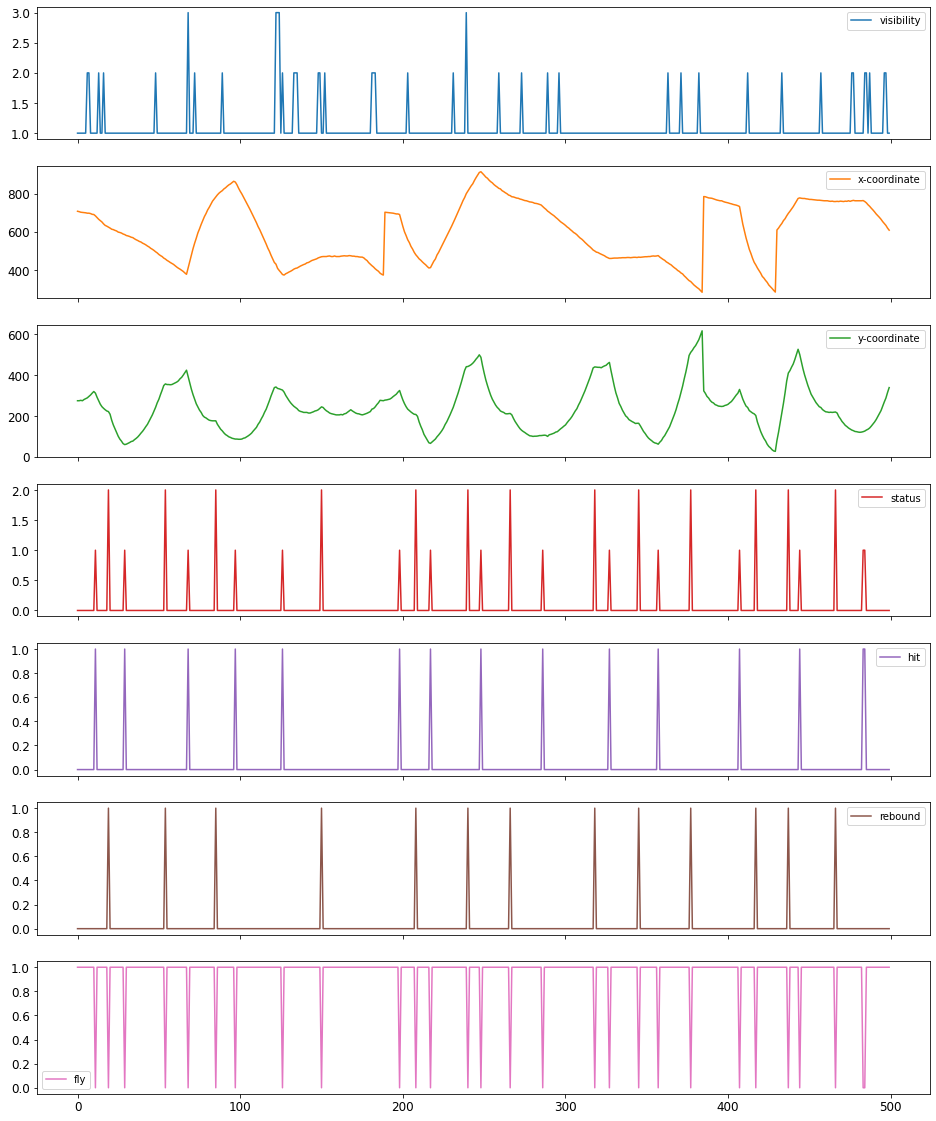

In [ ]:
#df.iloc[0:len(df)].plot(subplots=True, fontsize=12, figsize=(16,20))
df.iloc[0:500].plot(subplots=True, fontsize=12, figsize=(16,20))
plt.show()

# Train the model

Prepare dataset for training

In [ ]:
# ---- About training (Can be changed !)
#
scale            = 1       # Percentage of dataset to be used (1=all)
train_prop       = .8       # Percentage for train (the rest being for the test)
sequence_len     = 5
sequence_class_len = 5
batch_size       = 32
epochs           = 50
iterations       = 5        # number of iterations for prediction 

In [ ]:
# ---- About input dataset (no need to change)
#
features         = ['x-coordinate', 'y-coordinate']
features_len     = len(features)
print(features_len)
#features_class         = ['fly', 'rebound', 'hit']
features_class         = ['rebound']
features_class_len     = len(features_class)
print(features_class_len)

2
1


Train dataset example :


,x-coordinate,y-coordinate
0,708.0,274.0
1,706.0,274.0
2,703.0,276.0
3,702.0,274.0
4,701.0,280.0


       x-coordinate  y-coordinate
count  10315.000000  10315.000000
mean     644.262094    237.763015
std      144.127944    140.791944
min       79.000000      2.000000
25%      541.000000    135.000000
50%      647.000000    205.000000
75%      744.000000    321.500000
max     1279.000000    718.000000


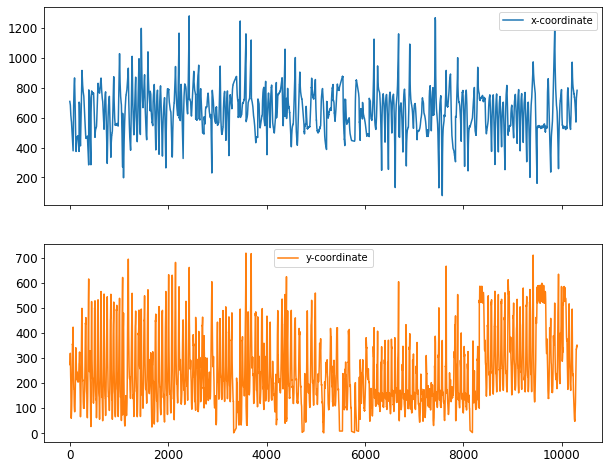

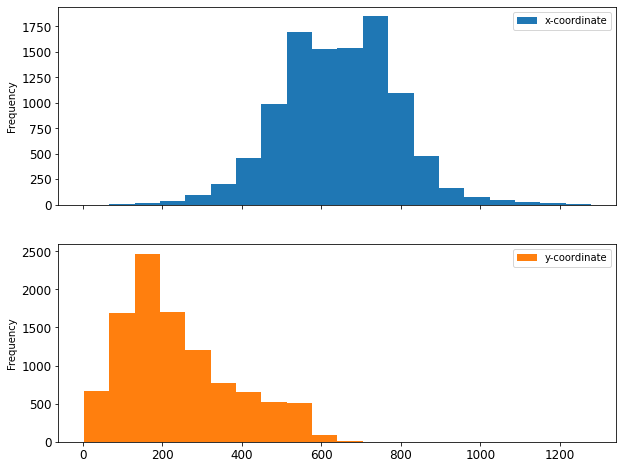

0.0    9770
1.0     275
2.0     270
Name: status, dtype: int64


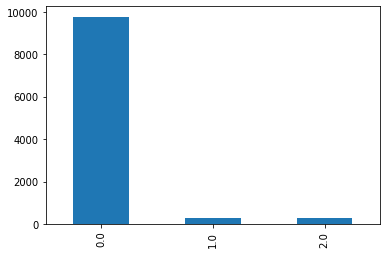

NameError: ignored

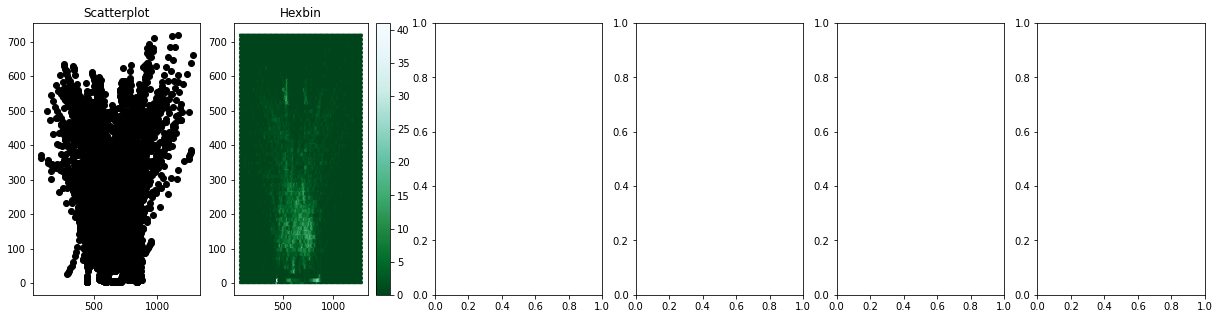

In [ ]:
# ---- Data set analysis
df = df[:int(scale*len(df))]
train_len=int(train_prop*len(df))
# ---- Data set
dataset = df.loc[ :, ['x-coordinate', 'y-coordinate'] ]
dataset_status = df.loc[ :, ['status'] ]

# sample
print('Train dataset example :')
display(dataset.head(5))

#data frame coord desciption
print(dataset.describe())
dataset.iloc[:].plot(subplots=True, fontsize=12, figsize=(10,8))
dataset.plot.hist(subplots=True, bins = 20, fontsize=12, figsize=(10,8))
plt.show()

#data frame class desciption
print(dataset_status.status.value_counts())
dataset_status.status.value_counts().plot(kind='bar') 
plt.show()

fig, axes = plt.subplots(ncols=6, nrows=1, figsize=(21, 5))
x = np.asarray(dataset.loc[ :, ['x-coordinate'] ])
y = np.asarray(dataset.loc[ :, ['y-coordinate'] ])
# Everything starts with a Scatterplot
axes[0].set_title('Scatterplot')
axes[0].plot(x, y, 'ko')
# Thus we can cut the plotting window in several hexbins
nbins = 100
axes[1].set_title('Hexbin')
cf = axes[1].hexbin(x, y, gridsize=nbins, cmap=plt.cm.BuGn_r)
fig.colorbar(cf, ax=axes[1])
# 2D Histogram
#axes[2].set_title('2D Histogram')
#axes[2].hist2d(x, y, bins=nbins, cmap=plt.cm.BuGn_r)
#plt.show()
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k = kde.gaussian_kde(dataset.T)
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# plot a density
axes[3].set_title('Calculate Gaussian KDE')
cf = axes[3].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=plt.cm.BuGn_r)
fig.colorbar(cf, ax=axes[3])
 
# add shading
axes[4].set_title('2D Density with shading')
cf = axes[4].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
fig.colorbar(cf, ax=axes[4])
 
# contour
axes[5].set_title('Contour')
axes[5].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
cf = axes[5].contour(xi, yi, zi.reshape(xi.shape) )
fig.colorbar(cf, ax=axes[5])
plt.show()


In [ ]:
# ---- Scaling

df = df[:int(scale*len(df))]
train_len=int(train_prop*len(df))

# ---- Train / Test
dataset_class_train = df.loc[ :train_len-1, features_class ]
dataset_class_test  = df.loc[train_len:,    features_class ]
print('Train class dataset example :')
display(dataset_class_train.head(15))

dataset_class_train = dataset_class_train.to_numpy()
dataset_class_test  = dataset_class_test.to_numpy()

print('Dataset       : ',df.shape)
print('Train dataset : ',dataset_class_train.shape)
print('Test  dataset : ',dataset_class_test.shape)

Train class dataset example :


,rebound
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


Dataset       :  (10315, 8)
Train dataset :  (8252, 1)
Test  dataset :  (2063, 1)


Train dataset example :


,x-coordinate,y-coordinate
0,708.0,274.0
1,706.0,274.0
2,703.0,276.0
3,702.0,274.0
4,701.0,280.0


After normalization dataset_train:
       x-coordinate  y-coordinate
count  8.252000e+03  8.252000e+03
mean  -3.744514e-16 -1.026808e-16
std    1.000000e+00  1.000000e+00
min   -3.955583e+00 -1.653236e+00
25%   -6.931817e-01 -6.912136e-01
50%    2.177015e-02 -2.338586e-01
75%    7.020156e-01  5.231427e-01
max    4.373953e+00  3.992732e+00


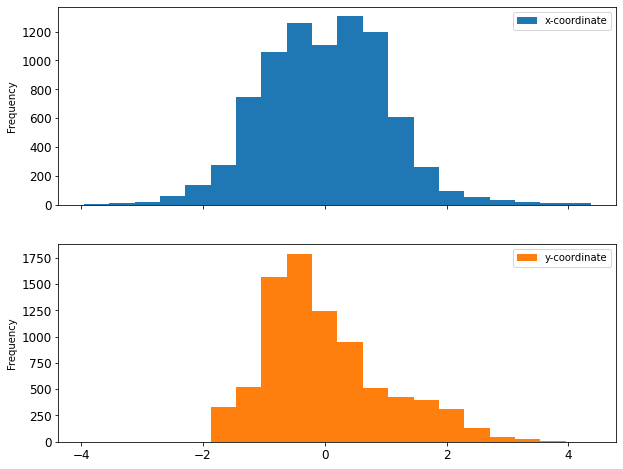

After normalization dataset_test:
       x-coordinate  y-coordinate
count   2063.000000   2063.000000
mean      -0.159704      1.029284
std        0.992168      1.147067
min       -3.386399     -1.290506
25%       -0.797301      0.042131
50%       -0.172586      0.877987
75%        0.563190      2.155427
max        3.707590      3.929649


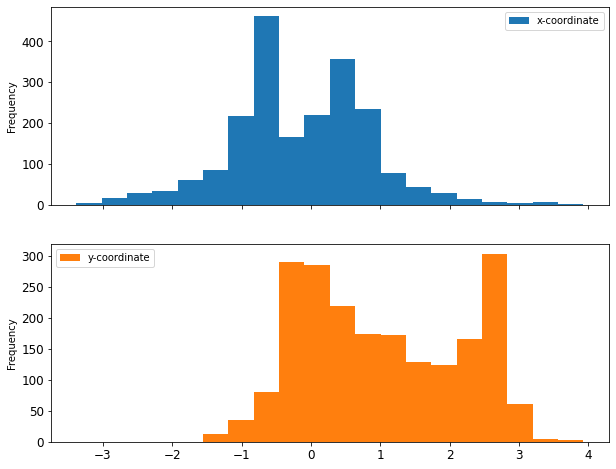

Dataset       :  (10315, 8)
Train dataset :  (8252, 2)
Test  dataset :  (2063, 2)


In [ ]:
# ---- Scaling x & y coord
df = df[:int(scale*len(df))]
train_len=int(train_prop*len(df))

# ---- Train / Test
dataset_train = df.loc[ :train_len-1, features ]
dataset_test  = df.loc[train_len:,    features ]
print('Train dataset example :')
display(dataset_train.head(5))

# ---- Normalize
mean = dataset_train.mean()
std  = dataset_train.std()
dataset_train = (dataset_train - mean) / std
dataset_test  = (dataset_test  - mean) / std

# ---- Normalize, and convert to numpy array
print('After normalization dataset_train:')
print(dataset_train.describe())
dataset_train.plot.hist(subplots=True, bins = 20, fontsize=12, figsize=(10,8))
plt.show()
print('After normalization dataset_test:')
print(dataset_test.describe())
dataset_test.plot.hist(subplots=True, bins = 20, fontsize=12, figsize=(10,8))
plt.show()


# convert to numpy
dataset_train = dataset_train.to_numpy()
dataset_test  = dataset_test.to_numpy()

print('Dataset       : ',df.shape)
print('Train dataset : ',dataset_train.shape)
print('Test  dataset : ',dataset_test.shape)

In [ ]:
# ---- Normalize, and convert to numpy array

mean = dataset_train.mean()
std  = dataset_train.std()
dataset_train = (dataset_train - mean) / std
dataset_test  = (dataset_test  - mean) / std

#data frame desciption
print(dataset_train.describe())

dataset_train.plot.hist(subplots=True, bins = 20, fontsize=12, figsize=(16,20))
dataset_test.plot.hist(subplots=True, bins = 20, fontsize=12, figsize=(16,20))

plt.show()

AttributeError: ignored

In [ ]:
# ---- Train generator

train_generator = TimeseriesGenerator(dataset_train, dataset_class_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(dataset_test,  dataset_class_test,  length=sequence_len,  batch_size=batch_size)
train_class_generator_0 = TimeseriesGenerator(dataset_class_train, dataset_class_train, length=sequence_class_len,  batch_size=batch_size, start_index=0, stride=sequence_len)
train_class_generator_1 = TimeseriesGenerator(dataset_class_train, dataset_class_train, length=sequence_class_len,  batch_size=batch_size, start_index=1, stride=sequence_len)
train_class_generator_2 = TimeseriesGenerator(dataset_class_train, dataset_class_train, length=sequence_class_len,  batch_size=batch_size, start_index=2, stride=sequence_len)
train_class_generator_3 = TimeseriesGenerator(dataset_class_train, dataset_class_train, length=sequence_class_len,  batch_size=batch_size, start_index=3, stride=sequence_len)
train_class_generator_4 = TimeseriesGenerator(dataset_class_train, dataset_class_train, length=sequence_class_len,  batch_size=batch_size, start_index=4, stride=sequence_len)
test_class_generator_0  = TimeseriesGenerator(dataset_class_test,  dataset_class_test,  length=sequence_class_len,  batch_size=batch_size, start_index=0, stride=sequence_len)
test_class_generator_1  = TimeseriesGenerator(dataset_class_test,  dataset_class_test,  length=sequence_class_len,  batch_size=batch_size, start_index=1, stride=sequence_len)
test_class_generator_2  = TimeseriesGenerator(dataset_class_test,  dataset_class_test,  length=sequence_class_len,  batch_size=batch_size, start_index=2, stride=sequence_len)
test_class_generator_3  = TimeseriesGenerator(dataset_class_test,  dataset_class_test,  length=sequence_class_len,  batch_size=batch_size, start_index=3, stride=sequence_len)
test_class_generator_4  = TimeseriesGenerator(dataset_class_test,  dataset_class_test,  length=sequence_class_len,  batch_size=batch_size, start_index=4, stride=sequence_len)


# replce train generator with class 
print('About the splitting of our dataset :')

x,y=train_generator[0]
print(f'Nombre de train batchs disponibles : ', len(train_generator))
print(train_generator)
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

x,y=train_generator[0]
print('What a batch looks like (x[0]) :')
print(x[0] )
print('What a batch looks like (y[0]) :')
print(y[0])

x,y=train_class_generator_1[0]
print(f'Nombre de train class  batchs disponibles : ', len(train_class_generator_1))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

x,y=train_class_generator_1[0]
print('What a batch looks like (x[0]) :')
print(x[0] )
print('What a batch looks like (y[0]) :')
print(y[0])


(8252, 2)
(8252, 1)
8252
5
Nombre de train class  batchs disponibles :  208
batch x shape :  (208, 9, 2)
batch y shape :  (208, 1, 9)
What a batch looks like (x[0]) :
[[ 0.07036338  0.35757033]
 [ 0.02177147  0.26293943]
 [-0.04764554  0.19985216]
 [-0.10317915  0.1446508 ]
 [-0.13094595  0.09733535]
 [-0.16565446  0.07367763]
 [-0.20036296 -0.02883918]
 [-0.24201317 -0.25753053]
 [-0.25589657 -0.43890642]]
What a batch looks like (y[0]) :
[[0 0 0 0 0 1 0 0 0]]


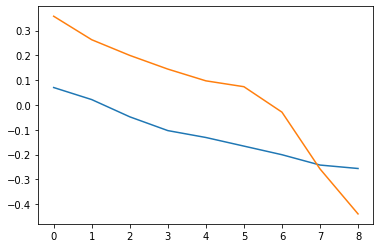

In [ ]:
#dataset generator custo with fixed
print(dataset_train.shape)
print(dataset_class_train.shape)
train_batch = []
train_class_batch = []
x = []
y = []
v = []
c = []
bs = 0
print(len(dataset_train))
print(sequence_len)

for i in range (0, len(dataset_train)-1-2*sequence_len):
  if dataset_class_train[i][0]==1:
    v = dataset_train[i-5:i+4,:]
    c = dataset_class_train[i-5:i+4,:]
    x.append(np.asarray(v))  
    y.append(np.transpose(c)) 

train_batch = np.asarray(x)
train_class_batch = np.asarray(y)


x = train_batch
y = train_class_batch
print(f'Nombre de train class  batchs disponibles : ', len(train_batch))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)
print('What a batch looks like (x[0]) :')
print(x[0] )
print('What a batch looks like (y[0]) :')
print(y[0])
plt.plot(x[0])

(8252, 2)
(8252, 1)
8252
5
Nombre de train class  batchs disponibles :  1045
batch x shape :  (1045, 5, 2)
batch y shape :  (1045, 1, 5)
What a batch looks like (x[0]) :
[[ 0.07035911  0.35754866]
 [ 0.02177015  0.2629235 ]
 [-0.04764265  0.19984005]
 [-0.1031729   0.14464204]
 [-0.13093802  0.09732945]]
What a batch looks like (y[0]) :
[[0 0 0 1 0]]


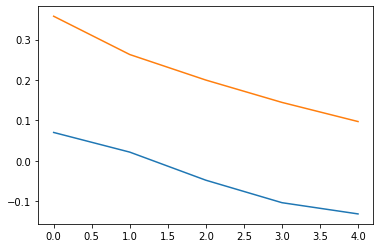

In [ ]:
#timeserie generator custo
print(dataset_train.shape)
print(dataset_class_train.shape)
train_batch = []
train_class_batch = []
x = []
y = []
v = []
c = []
bs = 0
print(len(dataset_train))
print(sequence_len)

for i in range (0, len(dataset_train)-1-2*sequence_len):
  if dataset_class_train[i+sequence_len][0]==1:
     for k1 in range (0, sequence_len):
       v = []
       c = []
       for k2 in range (0, sequence_len):
         vt = dataset_train[i+k1+k2]
         ct = dataset_class_train[i+k1+k2]
         v.append(vt)        
         c.append(ct)
       x.append(np.asarray(v))  
       y.append(np.transpose(c)) 

train_batch = np.asarray(x)
train_class_batch = np.asarray(y)
#train_class_batch = to_categorical(train_class_batch)

#train_batch = tf.convert_to_tensor(train_batch) 
#train_class_batch = tf.convert_to_tensor(train_class_batch)


#print(train_batch)
#print(train_class_batch)
#print(len(train_batch))

x = train_batch
y = train_class_batch
print(f'Nombre de train class  batchs disponibles : ', len(train_batch))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)
print('What a batch looks like (x[0]) :')
print(x[0] )
print('What a batch looks like (y[0]) :')
print(y[2])
plt.plot(x[0])

(2063, 2)
(2063, 1)
2063
5
Nombre de train test  batchs disponibles :  300
batch x shape :  (300, 5, 2)
batch y shape :  (300, 1, 5)
What a batch looks like (x[0]) :
[[-0.03376009 -0.1471189 ]
 [ 0.07035911  0.01058972]
 [ 0.19530216  0.19984005]
 [ 0.32718649  0.36543409]
 [ 0.47295337  0.59411158]]
What a batch looks like (y[0]) :
[[0 0 0 0 1]]


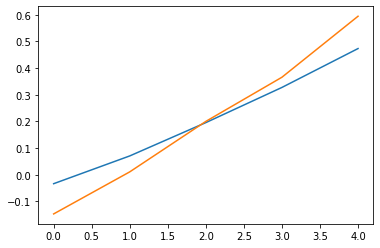

In [ ]:
from keras.utils.np_utils import to_categorical
print(dataset_test.shape)
print(dataset_class_test.shape)
test_batch = []
test_class_batch = []
x = []
y = []
v = []
c = []
bs = 0
print(len(dataset_test))
print(sequence_len)

for i in range (0, len(dataset_test)-1-2*sequence_len):
  if dataset_class_test[i+sequence_len][0]==1:
     for k1 in range (0, sequence_len):
       v = []
       c = []
       for k2 in range (0, sequence_len):
         vt = dataset_test[i+k1+k2]
         ct = dataset_class_test[i+k1+k2]
         v.append(vt)        
         c.append(ct)
       x.append(np.asarray(v))  
       y.append(np.transpose(c)) 

test_batch = np.asarray(x)
test_class_batch = np.asarray(y)
#test_class_batch = to_categorical(test_class_batch)

#test_batch = tf.convert_to_tensor(test_batch) 
#test_class_batch = tf.convert_to_tensor(test_class_batch) 
#test_batch = np.asarray(test_batch)
#test_class_batch = np.asarray(test_class_batch)

x = test_batch
y = test_class_batch
print(f'Nombre de train test  batchs disponibles : ', len(test_batch))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)
print('What a batch looks like (x[0]) :')
print(x[0] )
print('What a batch looks like (y[0]) :')
print(y[1])
plt.plot(x[0])


In [ ]:
#create model
model = keras.models.Sequential()
model.add( keras.layers.InputLayer(input_shape=(sequence_len, features_len)) )
model.add( keras.layers.GRU(10, activation='relu') )
model.add( keras.layers.Dropout(0.2) )
model.add( keras.layers.Dense(sequence_len, activation='sigmoid') )
#model.add( keras.layers.Dense(sequence_len, activation='softmax') )
model.add(tf.keras.layers.Reshape((sequence_len, 1)))
model.output_shape
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 10)                420       
                                                                 
 dropout_20 (Dropout)        (None, 10)                0         
                                                                 
 dense_22 (Dense)            (None, 5)                 55        
                                                                 
 reshape_16 (Reshape)        (None, 5, 1)              0         
                                                                 
Total params: 475
Trainable params: 475
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%mkdir (/content/run)

/bin/bash: -c: line 0: syntax error near unexpected token `/content/run'
/bin/bash: -c: line 0: `mkdir (/content/run)'


In [ ]:
save_dir = f'/content/run/best_model.h5'
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics   = ['accuracy'] )

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics   = ['accuracy'] )

In [ ]:
 model.compile(optimizer='adam', loss='mse', metrics   = ['mae'] )

In [ ]:
history = model.fit(train_batch, train_class_batch, epochs  = 200,  batch_size = batch_size, validation_data = (test_batch, test_class_batch), callbacks = [bestmodel_callback])

Epoch 1/200
33/33 [==============================] - 2s 16ms/step - loss: 0.6409 - accuracy: 0.6912 - val_loss: 0.5674 - val_accuracy: 0.7909
Epoch 2/200
33/33 [==============================] - 0s 7ms/step - loss: 0.6066 - accuracy: 0.7507 - val_loss: 0.5313 - val_accuracy: 0.8093
Epoch 3/200
33/33 [==============================] - 0s 7ms/step - loss: 0.5746 - accuracy: 0.7793 - val_loss: 0.5039 - val_accuracy: 0.8215
Epoch 4/200
33/33 [==============================] - 0s 8ms/step - loss: 0.5430 - accuracy: 0.7935 - val_loss: 0.4865 - val_accuracy: 0.8296
Epoch 5/200
33/33 [==============================] - 0s 7ms/step - loss: 0.5142 - accuracy: 0.8150 - val_loss: 0.4700 - val_accuracy: 0.8347
Epoch 6/200
33/33 [==============================] - 0s 8ms/step - loss: 0.4881 - accuracy: 0.8274 - val_loss: 0.4610 - val_accuracy: 0.8347
Epoch 7/200
33/33 [==============================] - 0s 7ms/step - loss: 0.4772 - accuracy: 0.8302 - val_loss: 0.4556 - val_accuracy: 0.8347
Epoch 8/200


In [ ]:
#history=model.fit(train_generator, epochs  = 300, validation_data = test_generator, callbacks = [bestmodel_callback])


# Prediction

In [ ]:
 loaded_model = tf.keras.models.load_model(f'/content/run/best_model.h5')

In [ ]:
s=random.randint(0,len(dataset_test)-sequence_len)

sequence      = dataset_test[s:s+sequence_len]
sequence_true = dataset_class_test[s:s+sequence_len]

pred = loaded_model.predict( np.array([sequence]) )

# ---- Show result
print (sequence)
print (sequence_true)
print(pred)

1/1 [==============================] - 0s 25ms/step
[[-0.75565325  2.70740698]
 [-0.74871197  2.88088646]
 [-0.73482941  2.96762619]
 [-0.75565325  2.90454275]
 [-0.75565325  2.79414672]]
[[0]
 [0]
 [1]
 [0]
 [0]]
[[[0.20145406]
  [0.20118079]
  [0.20124707]
  [0.20104179]
  [0.20206471]]]


In [ ]:
def denormalize(mean,std,seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq


# ---- Get a sequence

i=random.randint(0,len(dataset_test)-sequence_len)
sequence      = dataset_test[i:i+sequence_len]
sequence_true = dataset_test[i:i+sequence_len+1]

# ---- Prediction

pred = loaded_model.predict( np.array([sequence]) )

# ---- De-normalization

sequence_true = denormalize(mean,std, sequence_true)
pred          = denormalize(mean,std, pred)

# ---- Show it

#print(sequence)
#print(sequence_true)
#print(pred)

delta=abs(sequence_true[-1]-pred[-1])
print(delta)

#plot
x = sequence_true.T
plt.plot(x[0], x[1])
plt.scatter(x[0], x[1])
x[0][-1] = pred[0][0]
x[1][-1] = pred[0][1]
plt.plot(x[0], x[1])
plt.scatter(x[0][-1], x[1][-1])
plt.axis([0, 1280, 0, 640])
plt.show()

1/1 [==============================] - 0s 27ms/step


ValueError: ignored

# Full trajectory


In [ ]:
# ---- Initial sequence

s=random.randint(0,len(dataset_test)-sequence_len-iterations)

sequence_pred = dataset_test[s:s+sequence_len].copy()
sequence_true = dataset_test[s:s+sequence_len+iterations].copy()

# ---- Iterate on 4 predictions

sequence_pred=list(sequence_pred)

for i in range(iterations):
    sequence=sequence_pred[-sequence_len:]
    pred = loaded_model.predict( np.array([sequence]) )
    sequence_pred.append(pred[0])

# ---- Extract the predictions    

pred=np.array(sequence_pred[-iterations:])
       
# ---- Show result

print(sequence_true)
print(pred)

delta=abs(sequence_true[-1]-pred[-1])
print(delta)

1/1 [==============================] - 0s 24ms/step
[[-0.42787188  1.14932553]
 [-0.45080135  1.17718313]
 [-0.46608767  1.19111193]
 [-0.48901714  1.23289833]
 [-0.4966603   1.25379153]
 [-0.51958977  1.28164914]
 [-0.55780555  1.30254234]
 [-0.58837818  1.32343554]
 [-0.59602134  1.35825754]
 [-0.61130766  1.35129314]]
[[-0.5220129   1.2722851 ]
 [-0.5417615   1.2852786 ]
 [-0.5655584   1.2935861 ]
 [-0.58963645  1.2988774 ]
 [-0.6139143   1.302512  ]]
[0.00260665 0.04878109]


In [ ]:
def denormalize(mean,std,seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq


def get_prediction(dataset, model, iterations=4,sequence_len=16):

    # ---- Initial sequence

    s=random.randint(0,len(dataset)-sequence_len-iterations)

    sequence_pred = dataset[s:s+sequence_len].copy()
    sequence_true = dataset[s:s+sequence_len+iterations].copy()

    # ---- Iterate

    sequence_pred=list(sequence_pred)

    for i in range(iterations):
        sequence=sequence_pred[-sequence_len:]
        pred = model.predict( np.array([sequence]) )
        sequence_pred.append(pred[0])

    # ---- Extract the predictions    

    pred=np.array(sequence_pred[-iterations:])

    # ---- De-normalization

    sequence_true = denormalize(mean,std, sequence_true)
    pred          = denormalize(mean,std, pred)

    return sequence_true,pred

In [ ]:
  
sequence_true, pred = get_prediction(dataset_test, loaded_model,iterations=10)


print(sequence_true)
print(pred)

delta=abs(sequence_true[-1]-pred[-1])
print(delta)


1/1 [==============================] - 0s 23ms/step
[[682. 219.]
 [677. 211.]
 [674. 208.]
 [671. 198.]
 [669. 194.]
 [668. 190.]
 [665. 190.]
 [662. 186.]
 [661. 184.]
 [661. 182.]
 [657. 178.]
 [654. 179.]
 [651. 184.]
 [639. 186.]
 [629. 193.]
 [618. 205.]
 [609. 210.]
 [599. 224.]
 [586. 236.]
 [575. 251.]
 [561. 266.]
 [549. 288.]
 [534. 310.]
 [525. 330.]
 [510. 358.]
 [492. 387.]]
[[609.8795   204.84842 ]
 [604.8518   200.91057 ]
 [602.6772   190.13493 ]
 [602.5219   174.03958 ]
 [603.6085   153.19585 ]
 [605.8841   127.77106 ]
 [609.7368    97.57529 ]
 [615.8802    62.4136  ]
 [625.53503   22.175522]
 [639.9563   -22.939621]]
[147.95629883 409.93962097]


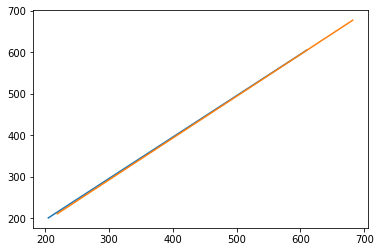

In [ ]:
plt.plot(pred[0], pred[1])
plt.plot(sequence_true[0], sequence_true[1])